# Inventures Prueba Tecnica

---


## Objetivo de este notebook


1. Generar un grafo a partir del dataset mencionado.
2. Crear una función que calcule el tiempo de traslado entre dos nodos del grafo.


## Preparación de los datos


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Cargar la data
df = pd.read_csv('vehicle_gps.csv')
# Chequear el tipo de dato de cada columna
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   vehicle    77 non-null     object 
 1   latitude   77 non-null     float64
 2   longitude  77 non-null     float64
 3   timestamp  77 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.5+ KB


In [3]:
# Cambiar timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])


## Breve exploración de los datos


In [4]:
# Exploración de la data

# Funcion para calcular la distancia euclidiana entre dos coordenadas en metros

def calcular_distancia(coord1, coord2):
    R = 6371000  # Radio de la Tierra en metros

    lat1, lon1 = np.radians(coord1[0]), np.radians(coord1[1])
    lat2, lon2 = np.radians(coord2[0]), np.radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    distancia = R * c
    return distancia

def coordenadas_unicas(df):
    unique_coordinates = df[['latitude', 'longitude']].drop_duplicates()
    unique_coordinates['coordinates'] = unique_coordinates['latitude'].astype(str) + ',' + unique_coordinates['longitude'].astype(str)
    return unique_coordinates

# Buscar por valores nulos
print("Cantidad de valores nulos por columna:")
print(df.isnull().sum(), '\n')

# Cuantos vehiculos hay en la data?
print('Cantidad de vehiculos: ', df['vehicle'].nunique())

# Cuantos nodos hay en la data?
print('Cantidad de registros: ', df.shape[0])
print('Cantidad de nodos unicos: ', coordenadas_unicas(df).shape[0])

# Agregar columna con coordenadas concatenadas
df['coordinates'] = df['latitude'].astype(str) + ',' + df['longitude'].astype(str)


Cantidad de valores nulos por columna:
vehicle      0
latitude     0
longitude    0
timestamp    0
dtype: int64 

Cantidad de vehiculos:  4
Cantidad de registros:  77
Cantidad de nodos unicos:  75


Vehiculo  A :
Distancia promedio:  45.02545560293728
Desviacion estandar:  21.46424278550097 

Vehiculo  B :
Distancia promedio:  56.50395693254976
Desviacion estandar:  34.09958508526737 

Vehiculo  C :
Distancia promedio:  72.55017997690172
Desviacion estandar:  42.36232761514504 

Vehiculo  D :
Distancia promedio:  55.8846259971249
Desviacion estandar:  28.649773682903533 



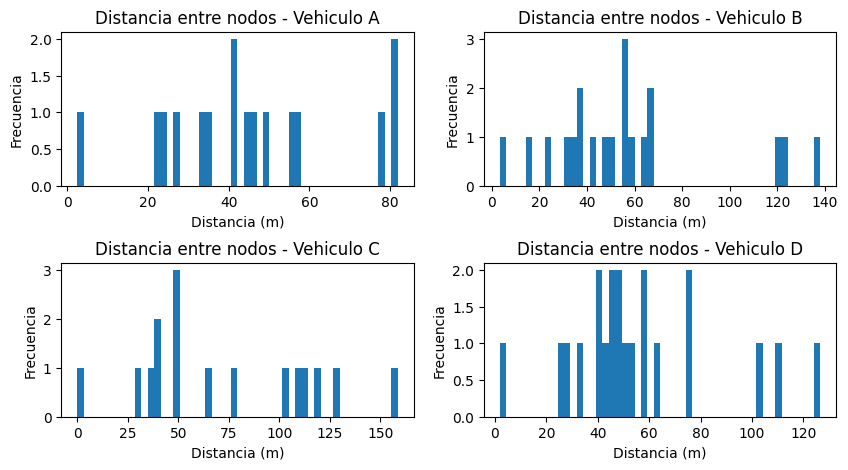

In [5]:
# Histograma de la distancia entre todos los nodos para cada vehiculo
fig, ax = plt.subplots(2,2,figsize=(10, 5), dpi=100)

# turn each vehicle into a number (A = 0, B = 1, C = 2, D = 3)
to_number = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

for vehicle in df['vehicle'].unique():
    distancias = []
    df_vehicle = df[df['vehicle'] == vehicle]
    for i in range(df_vehicle.shape[0] - 1):
        coord1 = df_vehicle.iloc[i][['latitude', 'longitude']]
        coord2 = df_vehicle.iloc[i + 1][['latitude', 'longitude']]
        distancias.append(calcular_distancia(coord1, coord2))
    ax[to_number[vehicle]//2, to_number[vehicle]%2].hist(distancias, bins=50)
    ax[to_number[vehicle]//2, to_number[vehicle]%2].set_title('Distancia entre nodos - Vehiculo ' + vehicle)
    ax[to_number[vehicle]//2, to_number[vehicle]%2].set_xlabel('Distancia (m)')
    ax[to_number[vehicle]//2, to_number[vehicle]%2].set_ylabel('Frecuencia')

    #Imprimir la distancia promedio y la desviacion estandar
    print('Vehiculo ', vehicle, ':')
    print('Distancia promedio: ', np.mean(distancias))
    print('Desviacion estandar: ', np.std(distancias), '\n')

plt.subplots_adjust(hspace=0.5)
plt.show()

En base a estas observaciones, se puede concluir que el vehículo A tiende a operar dentro de un rango de distancias entre nodos relativamente consistente, mientras que el vehículo C cubre un rango más amplio. Los vehículos B y D se encuentran en un punto intermedio, con una variabilidad moderada en las distancias. Estas diferencias podrían indicar variaciones en los patrones de viaje, las rutas o las características operativas de los vehículos.

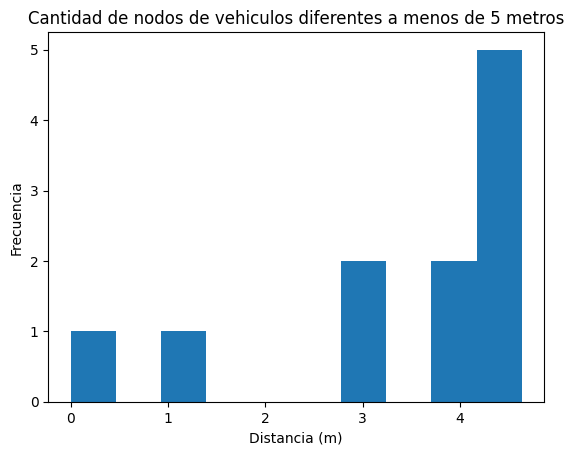

In [6]:
# Coordenadas donde dos vehiculos esten a menos de 5 metros
distancias = []
for i in range(df.shape[0] - 1):
    coord1 = df.iloc[i][['latitude', 'longitude']]
    for j in range(i + 1, df.shape[0]):
        coord2 = df.iloc[j][['latitude', 'longitude']]
        if calcular_distancia(coord1, coord2) < 5:
            if df.iloc[i]['vehicle'] != df.iloc[j]['vehicle']:
              distancias.append(calcular_distancia(coord1, coord2))

plt.hist(distancias, bins=10)
plt.title('Cantidad de nodos de vehiculos diferentes a menos de 5 metros')
plt.xlabel('Distancia (m)')
plt.ylabel('Frecuencia')
plt.show()

Con base en esta información, es posible que estos vehículos estén utilizando la misma calle en ciertos momentos o compartan una ruta común. Sin embargo, es importante tener en cuenta que esta inferencia se basa en la suposición de que la proximidad espacial de los nodos refleja una conexión en el recorrido de los vehículos.

## Construccion y Visualizacion del Grafo


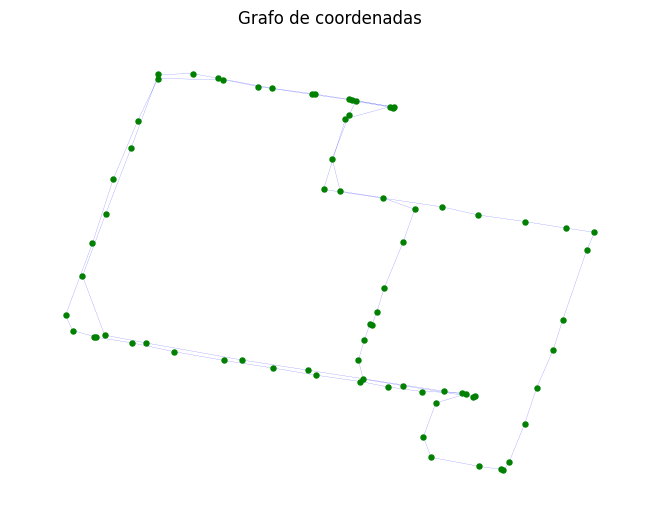

In [7]:
# Ordenar el dataset por fecha y vehiculo
df = df.sort_values(by=['vehicle', 'timestamp'])


def create_graph(df):
    # Crear un grafo vacio
    G = nx.Graph()

    # Agregar los nodos al grafo
    for index, row in coordenadas_unicas(df).iterrows():
        node = row['coordinates']
        G.add_node(node, pos=(row['latitude'], row['longitude']))

    # agregar aristas al grafo
    prev_coordinates = {}

    for index, row in df.iterrows():
        vehicle = row['vehicle']
        coordinates = row['coordinates']

        if vehicle not in prev_coordinates:
            prev_coordinates[vehicle] = coordinates
        else:
            if prev_coordinates[vehicle] != coordinates:
                # si la arista ya existe, actualizar el peso con el promedio de los tiempos
                if G.has_edge(prev_coordinates[vehicle], coordinates):
                    G.edges[prev_coordinates[vehicle], coordinates]['weight'] = (
                        G.edges[prev_coordinates[vehicle], coordinates]['weight'] + (df['timestamp'][index] - df['timestamp'][index-1]).total_seconds())/2
                else:
                    G.add_edge(prev_coordinates[vehicle], coordinates, weight=(
                        df['timestamp'][index] - df['timestamp'][index-1]).total_seconds())
            prev_coordinates[vehicle] = coordinates
    return G


G = create_graph(df)
# Visualizar el Grafo
node_positions = nx.get_node_attributes(G, 'pos')
nx.draw(G, node_size=13, pos=node_positions, font_size=8, font_color='r',
        font_weight='bold', width=0.1, edge_color='b', node_color='g')
plt.title('Grafo de coordenadas')
plt.show()


### ¿El grafo es conexo?


El grafo no es conexo


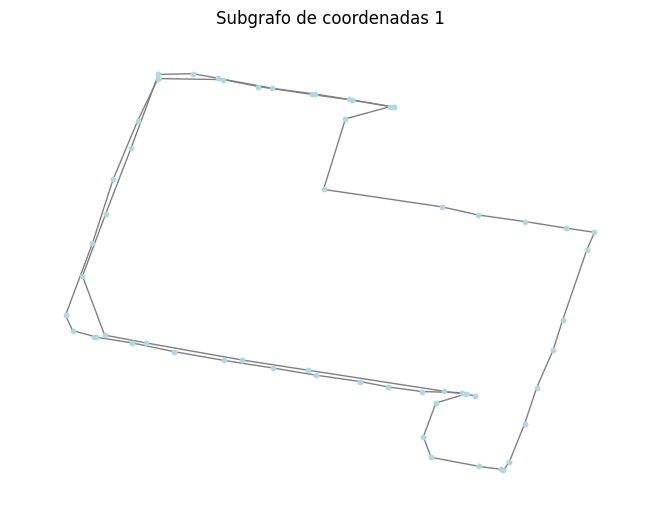

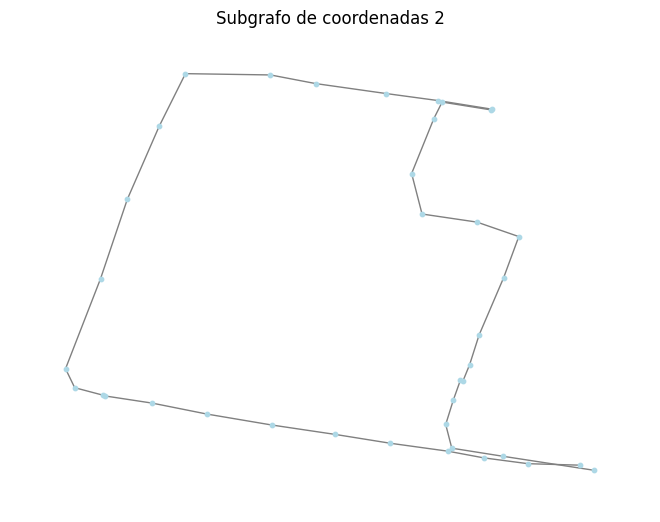

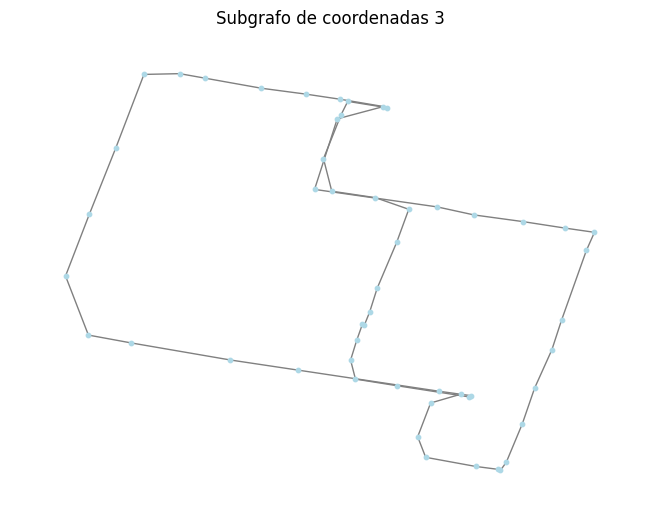

In [8]:
if nx.is_connected(G):
    print('El grafo es conexo')
else:
    print('El grafo no es conexo')

# Encontrar los nodos no conexos
non_connected_nodes = [list(component)
                       for component in nx.connected_components(G)]
all_nodes = set(G.nodes())
non_connected_nodes = [list(all_nodes - set(component))
                       for component in non_connected_nodes]

# Draw each component separately
for i, component in enumerate(non_connected_nodes):
    # Create a subgraph for the component
    subgraph = G.subgraph(component)

    # Draw the subgraph
    plt.figure()
    node_positions = nx.get_node_attributes(subgraph, 'pos')
    nx.draw(subgraph, pos=node_positions, node_color='lightblue',
            node_size=10, edge_color='gray')
    plt.title("Subgrafo de coordenadas " + str(i+1))

# Show all the plots
plt.show()


Debido a que el grafo original no es completamente conexo y se divide en tres subgrafos completamente conexos, no es posible calcular directamente la distancia entre nodos que pertenecen a subgrafos diferentes. Para solucionar esto, se realiza una unión de los subgrafos conectando los nodos que se encuentran a una distancia determinada.

Para determinar la distancia adecuada, se utilizará el algoritmo de iteración del punto medio. Este algoritmo calcula límite o treshold en el cual el grafo se vuelve conexo perdiendo la menor cantidad de nodos.

Al unir los subgrafos utilizando esta distancia, se logra obtener un grafo completamente conexo, minimizando la pérdida de nodos. Esto permite realizar cálculos de distancia entre cualquier par de nodos en el grafo resultante.

Es importante tener en cuenta que la elección de la distancia y el algoritmo utilizado pueden variar según el contexto y los requisitos específicos del problema. En este caso, el enfoque mencionado proporciona una solución que preserva la mayor cantidad posible de nodos en el grafo final.


In [9]:
# Funcion para combinar nodos que estan a menos de x metros de distancia, donde x es el parametro threshold


def merge_coordinates(df, threshold):
    for index, row in df.iterrows():
        current_coordinate = (row['latitude'], row['longitude'])
        for index2, row2 in df.iterrows():
            if index == index2:
                continue
            next_coordinate = (row2['latitude'], row2['longitude'])
            if calcular_distancia(current_coordinate, next_coordinate) < threshold:
                df.at[index, 'latitude'] = (
                    current_coordinate[0]+next_coordinate[0])/2
                df.at[index, 'longitude'] = (
                    current_coordinate[1]+next_coordinate[1])/2
                df.at[index2, 'latitude'] = (
                    current_coordinate[0]+next_coordinate[0])/2
                df.at[index2, 'longitude'] = (
                    current_coordinate[1]+next_coordinate[1])/2
                df.at[index, 'coordinates'] = str(
                    (current_coordinate[0]+next_coordinate[0])/2) + ',' + str((current_coordinate[1]+next_coordinate[1])/2)
                df.at[index2, 'coordinates'] = str(
                    (current_coordinate[0]+next_coordinate[0])/2) + ',' + str((current_coordinate[1]+next_coordinate[1])/2)

    return df


In [10]:
#  Se definen las cotas para la iteracion de punto medio
limite_de_cambio = .000001
cota_superior = 10.0
cota_inferior = 0.0

#  Se realiza la iteracion de punto medio para calcular la distancia que propicia la menor perdida de nodos
while cota_superior - cota_inferior > limite_de_cambio:
    test = merge_coordinates(df.copy(), (cota_superior+cota_inferior)/2)
    G_test = create_graph(test)
    if nx.is_connected(G_test):
        cota_superior = (cota_superior+cota_inferior)/2
    else:
        cota_inferior = (cota_superior+cota_inferior)/2

print('La distancia optima para la combinación de nodos cercanos es: ' + str((cota_superior+cota_inferior)/2))


La distancia optima para la combinación de nodos cercanos es: 3.1805190443992615


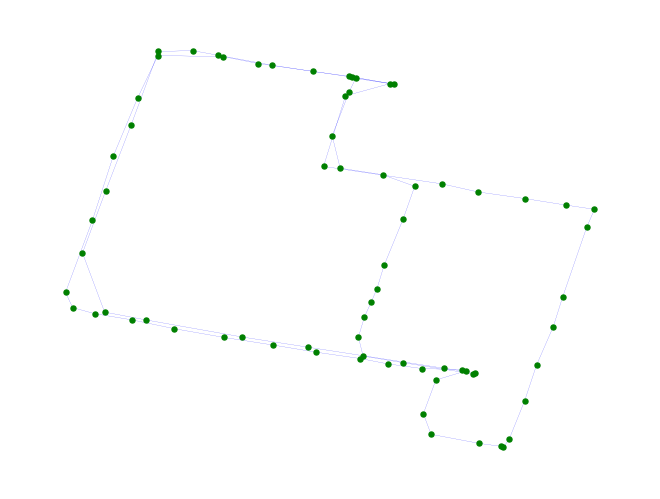

El grafo es conexo


In [11]:
# Se crea el grafo con la cota superior
merged_df = merge_coordinates(df.copy(), cota_superior)

G_edited = create_graph(merged_df)

# Se visualiza el nuevo grafo
node_positions = nx.get_node_attributes(G_edited, 'pos')
nx.draw(G_edited, node_size=13, pos=node_positions,
        font_size=8, width=0.1, edge_color='b', node_color='g')
plt.show()

# Se verifica que el grafo sea conexo
if nx.is_connected(G_edited):
    print('El grafo es conexo')
else:
    print('El grafo no es conexo')


Como se puede observar, hemos logrado obtener un grafo completamente conexo que incluye deltas de tiempo para cada arco que conecta los nodos. Dado que no tenemos información sobre la configuración o dirección de las calles por las cuales los vehículos se desplazan, es crucial preservar la estructura original del grafo en la medida de lo posible, manteniendo caminos paralelos que podrían indicar vías de sentido único u otros detalles que podríamos desconocer y perder si simplificamos aún más la cantidad de nodos presentes.


## Calculadora de distancias


En NetworkX, puedes utilizar la función `shortest_path_length()` para calcular el costo entre dos nodos en un grafo ponderado. Esta función devuelve la longitud del camino más corto entre los nodos, tomando en cuenta el peso de las aristas si el grafo está ponderado. También puedes utilizar la función `shortest_path()` para obtener la secuencia de nodos que conforman ese camino más corto.

La función `shortest_path_length()` utiliza dos algoritmos para encontrar el camino más corto en un grafo ponderado: Dijkstra y Bellman-Ford. La principal diferencia entre ellos es su complejidad temporal. El algoritmo de Dijkstra tiene una complejidad de tiempo de $O(E \log V)$, donde $V$ es el número de nodos en el grafo y $E$ es el número de arcos. Por otro lado, el algoritmo de Bellman-Ford tiene una complejidad de tiempo de $O(EV)$.

Una ventaja del algoritmo de Bellman-Ford es que puede manejar aristas con pesos negativos, mientras que el algoritmo de Dijkstra no puede. Sin embargo, debido a su mayor complejidad temporal, el algoritmo de Dijkstra es más eficiente en este caso debido a que estamos ante un grafo con pesos no negativos.


In [12]:
# Funcion para calcular la distancia entre dos nodos en el grafo, recibe como parametro el grafo y las coordenadas de los nodos como strings
def shortest_time(G, cord1, cord2):
    return (nx.shortest_path_length(G, cord1, cord2, weight='weight'), nx.shortest_path(G, cord1, cord2, weight='weight'))


# Prueba de la funcion shortest_path con dos nodos aleatorios
sample_a, sample_b = merged_df.sample(n=2)["coordinates"].values
time, path = shortest_time(G_edited, sample_a, sample_b)

minutos = time/60
segundos = time % 60

print(
    f"El tiempo de viaje más corto entre los nodos ({sample_a}) y ({sample_b}) es de:")
print(f"{minutos} minutos y {segundos} segundos")
print("==========================")
print("El camino utilizado fue:")
for index, node in enumerate(path):
    print(f"{index + 1}. ({node})")


El tiempo de viaje más corto entre los nodos (-33.417517000000004,-70.58738249999999) y (-33.416183,-70.593192) es de:
18.0 minutos y 0.0 segundos
El camino utilizado fue:
1. (-33.417517000000004,-70.58738249999999)
2. (-33.417943,-70.587252)
3. (-33.41834299999999,-70.58714724999999)
4. (-33.417979,-70.587237)
5. (-33.417554,-70.58737)
6. (-33.418011,-70.587596)
7. (-33.418235,-70.588889)
8. (-33.417023,-70.58921)
9. (-33.41666,-70.589357)
10. (-33.416174,-70.58948)
11. (-33.415762,-70.589598)
12. (-33.415469,-70.589676)
13. (-33.415549,-70.590009)
14. (-33.415794,-70.591285)
15. (-33.41589,-70.59183)
16. (-33.41606,-70.59253)
17. (-33.416183,-70.593192)
